<a href="https://colab.research.google.com/github/mldurga/projects/blob/main/wagon_shipment_reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install paddlepaddle paddleocr

In [ ]:
 ocr = PaddleOCR(use_angle_cls=True, lang=lang,use_gpu=False)
    img_path = img.name
    result = ocr.ocr(img_path, cls=True)
    image = Image.open(img_path).convert('RGB')
    boxes = [line[0] for line in result]
    txts = [line[1][0] for line in result]
    scores = [line[1][1] for line in result]
    im_show = draw_ocr(image, boxes, txts, scores,
                       font_path='simfang.ttf')
    im_show = Image.fromarray(im_show)
    im_show.save('result.jpg')

In [5]:
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image
# import gradio as gr
import torch

In [6]:
 ocr = PaddleOCR(use_angle_cls=True, lang='en',use_gpu=False)
 img_path='/content/IMG-20211209-WA0010.jpg'
 result = ocr.ocr(img_path, cls=True)

[2021/12/14 12:20:57] root WARNING: lang en is not support in PP-OCRv2, auto switch to version PP-OCR
[2021/12/14 12:20:57] root WARNING: lang en is not support in PP-OCRv2, auto switch to version PP-OCR
[2021/12/14 12:20:57] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
download https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/en_ppocr_mobile_v2.0_det_infer.tar to /root/.paddleocr/2.3.0.2/ocr/det/en/en_ppocr_mobile_v2.0_det_infer/en_ppocr_mobile_v2.0_det_infer.tar


100%|██████████| 3.16M/3.16M [00:15<00:00, 205kiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/en_number_mobile_v2.0_rec_infer.tar to /root/.paddleocr/2.3.0.2/ocr/rec/en/en_number_mobile_v2.0_rec_infer/en_number_mobile_v2.0_rec_infer.tar


100%|██████████| 2.70M/2.70M [00:11<00:00, 234kiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 1.45M/1.45M [00:13<00:00, 111kiB/s]


Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/2.3.0.2/ocr/det/en/en_ppocr_mobile_v2.0_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_polygon=True, e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set='totaltext', enable_mkldnn=False, gpu_mem=500, hel

In [10]:
result

[[[[51.0, 25.0], [257.0, 25.0], [257.0, 48.0], [51.0, 48.0]],
  ('11:26', 0.9383499)],
 [[[410.0, 22.0], [675.0, 22.0], [675.0, 50.0], [410.0, 50.0]],
  ('67%', 0.9898164)],
 [[[259.0, 86.0], [460.0, 90.0], [459.0, 130.0], [259.0, 126.0]],
  ('Google Lens', 0.9992869)],
 [[[350.0, 362.0], [439.0, 362.0], [439.0, 923.0], [350.0, 923.0]],
  ('SECR 21141076037', 0.91239053)],
 [[[177.0, 1158.0], [283.0, 1158.0], [283.0, 1182.0], [177.0, 1182.0]],
  ('Translate', 0.9917483)],
 [[[332.0, 1156.0], [389.0, 1161.0], [388.0, 1184.0], [331.0, 1179.0]],
  ('Text', 0.91819274)],
 [[[439.0, 1162.0], [518.0, 1162.0], [518.0, 1180.0], [439.0, 1180.0]],
  ('Search', 0.99812603)],
 [[[571.0, 1158.0], [693.0, 1160.0], [692.0, 1183.0], [570.0, 1182.0]],
  ('Homework', 0.97398114)],
 [[[43.0, 1242.0], [312.0, 1242.0], [312.0, 1275.0], [43.0, 1275.0]],
  ("'SECR 21141076037", 0.9770326)],
 [[[26.0, 1325.0], [191.0, 1325.0], [191.0, 1358.0], [26.0, 1358.0]],
  ('Copy text', 0.97663224)],
 [[[241.0, 1330.0],

In [12]:
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]


In [15]:
im_show = draw_ocr(image, boxes, txts, scores,font_path='/content/simfang.ttf')
im_show = Image.fromarray(im_show)

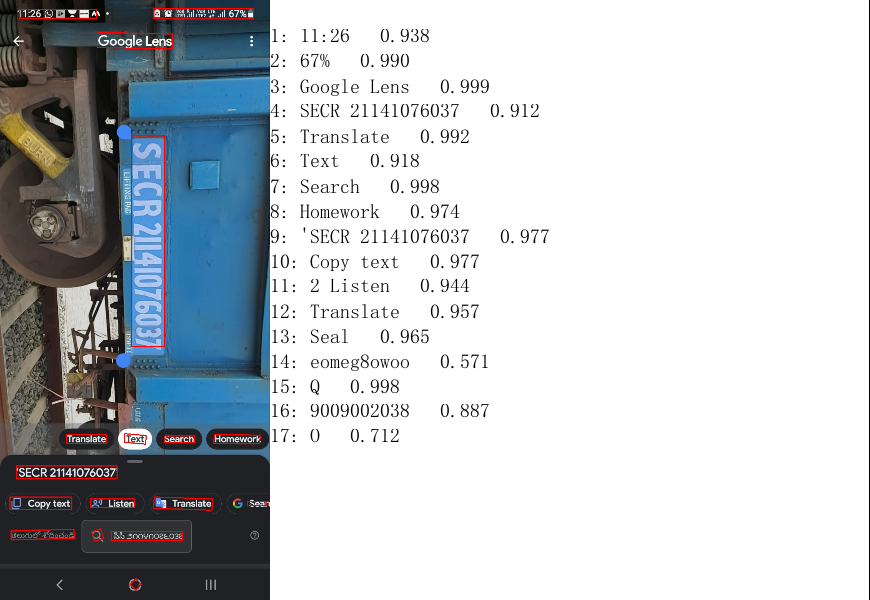

In [16]:
im_show